# Building Your Multimodal Search Store: Empowering Healthcare with Azure 🚀

Welcome to this hands‑on tutorial where we combine cutting‑edge AI, Azure Cognitive Search, and clinical image analysis to build a vector‑based knowledge store. In this session, you’ll learn how to leverage the MedImageInsight embeddings model to search and retrieve similar chest X‑ray images based on their semantic content. Along the way, we’ll also explore the healthcare significance of DICOM images and key chest X‑ray classifications such as **Cardiomegaly, No Findings, Pleural Effusion/Atelectasis,** and **Support Devices**.

> **Did you know?**  
> DICOM (Digital Imaging and Communications in Medicine) is the standard format for medical imaging data. It contains not only the image but also rich metadata that helps radiologists diagnose conditions. Chest X‑rays are one of the most common and informative imaging studies in healthcare, assisting in the detection of heart enlargement (cardiomegaly), fluid in the lungs (pleural effusion), lung collapse (atelectasis), and even the presence of support devices such as pacemakers.

---

## 📝 What You’ll Build

In this tutorial, you will create an end‑to‑end multimodal search solution that:
- **Generates embeddings:** Uses the MedImageInsight model to convert chest X‑ray images into high‑dimensional vectors capturing their visual and semantic features.
- **Indexes documents:** Combines image metadata (e.g., image name, category, and clinical label) with the embedding vector and uploads them to an Azure Cognitive Search index.
- **Performs vector searches:** Retrieves and displays similar images from your index based on a query image’s embedding vector.

---

## 🔧 Prerequisites

Before you start, make sure you have:

- An **Azure Subscription**
- Access to **AI Foundry** and **AI Search**
- A **GPU Quota** to deploy MedImageInsights
- [Python Magic](https://pypi.org/project/python-magic/) installed for image handling
- A basic understanding of DICOM images and chest X‑ray interpretation

---

## 📚 Our Approach

We will walk through the following key steps:

1. **Setup & Imports:** Load necessary libraries and set up your Azure resources.
2. **Testing MedImageInsight:** Verify that the embedding model correctly processes a sample chest X‑ray.
3. **Creating the Embedding Index:** Generate embeddings for your entire image catalog and merge them with metadata.
4. **Baseline Image Search:** Select a sample image, generate its embedding, and perform a vector search to retrieve similar images.
5. **Performance Optimization:** Discuss tuning techniques to refine the search results and improve precision.

### Healthcare Domain Spotlight: Chest X‑ray Classifications

- **Cardiomegaly:** Indicates an enlarged heart, often associated with various cardiac conditions.
- **No Findings:** Represents a normal chest X‑ray with no abnormal signs.
- **Pleural Effusion/Atelectasis:**  
  - **Pleural Effusion:** Fluid accumulation in the pleural space surrounding the lungs.  
  - **Atelectasis:** Partial or complete collapse of a lung, reducing gas exchange.
- **Support Devices:** Includes medical devices such as pacemakers or endotracheal tubes visible on the X‑ray, critical for patient management.

Understanding these classifications is vital because each category informs different diagnostic and treatment pathways in clinical settings.

---

# 💻 Notebook Walkthrough

### 0. Imports and Setup

Begin by importing all required libraries, setting up Azure Cognitive Search, and preparing your environment for processing DICOM files and image embeddings.



In [1]:
import re
from dotenv import load_dotenv
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
import numpy as np
import json
from azure.storage.blob import BlobServiceClient, ContentSettings
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SearchField,
    SimpleField,
    SearchableField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    HnswParameters,
    VectorSearchProfile
)
import os
import pydicom
import requests
from PIL import Image as PILImage
from io import BytesIO
import matplotlib.pyplot as plt
from azure.search.documents.models import VectorizedQuery
from datetime import datetime, timedelta
from azure.storage.blob import BlobClient, BlobSasPermissions, generate_blob_sas

from src.clients.medimageinsight import MedImageInsightClient
from src.utils.io import read_dicom_to_array, normalize_image_to_uint8, numpy_to_image_bytearray

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "med-images-index")
embedding_dim = int(os.environ.get("MEDIMAGEPARSE_MODEL_DIMENSIONS", "1024"))
blob_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
blob_container_name = os.environ.get("AZURE_IMAGES_CONTAINER_NAME", "medical-images")
root = os.path.dirname(os.getcwd())
images_folder = os.path.join(root, 'utils', 'data', 'images')
images_label_csv = os.path.join(images_folder, '.csv')
endpoint = os.environ.get("MI2_MODEL_ENDPOINT")
med_image_insight_client = MedImageInsightClient()

### 1. Test MedImageInsight Functionality 🎯

Test the embedding generation by processing a sample DICOM image. This step ensures that the MedImageInsight model is correctly deployed and ready to generate embeddings from your chest X‑rays.

200


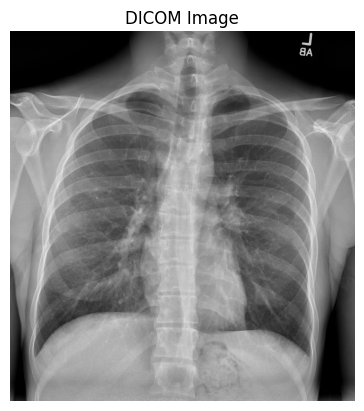

In [2]:
import glob
image_files = list(glob.glob(f"{root}/utils/data/images/raw" + "/*.dcm"))

encoded_image = med_image_insight_client._read_and_encode_image(image=image_files[1])

data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [encoded_image, "Cardiomegaly"]
        ],
    },
    "params": {"get_scaling_factor": True},
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ.get('MI2_MODEL_KEY')}"
}

url = os.environ.get("MI2_MODEL_ENDPOINT")
response = requests.post(url, headers=headers, json=data)
print(response.status_code)

# Load and display a DICOM image sample
ds = pydicom.dcmread(image_files[1])
img_array = ds.pixel_array

plt.imshow(img_array, cmap="gray")
plt.title("DICOM Image")
plt.axis("off")
plt.show()

### 2. Building the Embedding Index 🔍

Generate embeddings for each DICOM image from your catalog. For each image, you’ll upload the file to Azure Blob Storage, compute its embedding using the MedImageInsight model, and store the resulting vector along with metadata in your search index.

In [3]:
def generate_medical_embeddings(file_name: str, text_descr: str) -> dict:
    encoded_image = med_image_insight_client._read_and_encode_image(image=image_files[0])
    data = {
        "input_data": {
            "columns": ["image", "text"],
            "index": [0],
            "data": [
                [encoded_image, text_descr]
            ],
        },
        "params": {"get_scaling_factor": True},
    }
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.environ.get('MI2_MODEL_KEY')}"
    }
    
    url = os.environ.get("MI2_MODEL_ENDPOINT")
    response = requests.post(url, headers=headers, json=data)
    return json.loads(response.text)[0]

Additional helper functions handle tasks like uploading DICOM files to Blob Storage and normalizing document keys for consistency. These are essential for ensuring your images and metadata are indexed correctly.


In [4]:
# Helper functions

def upload_dicom_to_blob(file_path: str, container_client, folder: str = "raw") -> str:
    """
    Uploads a file to Blob Storage into a specified folder.
    If the blob already exists, the function returns its URL without re-uploading.
    """
    file_name = os.path.basename(file_path)
    # Create a blob name that places the file under the "raw" folder
    blob_name = f"{folder}/{file_name}"
    blob_client = container_client.get_blob_client(blob_name)
    
    # Check if the blob already exists; if so, skip upload
    if blob_client.exists():
        return blob_client.url
    
    with open(file_path, "rb") as data:
        blob_client.upload_blob(
            data, 
            overwrite=True, 
            content_settings=ContentSettings(content_type="application/dicom")
        )
    return blob_client.url

def normalize_document_key(key: str) -> str:
    """
    Normalize a document key by replacing any character not in the allowed set
    (letters, digits, underscore, dash, or equal sign) with an underscore.
    """
    # Allowed characters: A-Z, a-z, 0-9, underscore, dash, equal sign.
    normalized_key = re.sub(r"[^A-Za-z0-9_\-=]", "_", key)
    return normalized_key

In [5]:
# labeled images
dcm_labels = os.path.join(root, "utils", "data", "images", "dcm_labels.csv")

# storage helpers
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(blob_container_name)

# search
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

In [6]:
df = pd.read_csv(dcm_labels)
df = df.rename(columns={
    "Name": "name",
    "Label Category": "label_category",
    "Label": "label"
})

In [8]:
documents = []  # list of documents to upsert in Azure Search
image_folder = os.path.join(root, "utils", "data", "images", "raw") 

# upload into blob and generate the DF for Search processing
for idx, row in df.iterrows():
    file_name = row["name"]
    # Construct the full path to the DICOM file
    file_path = os.path.join(image_folder, file_name)
    
    # Upload the file to Blob Storage under the "raw" folder
    blob_url = upload_dicom_to_blob(file_path, container_client, folder="raw")
    
    # Combine text description for embedding generation (e.g., label_category + label)
    text_descr = f"{row['label_category']}"
    
    # Generate the embedding and scaling factor using the helper function
    embedding_result = generate_medical_embeddings(file_path, text_descr)
    vector = embedding_result.get("image_features") # the embedding vector
    scaling_factor = embedding_result.get("scaling_factor")
    
    # Create a document matching the Azure Search index schema
    doc = {
        "name": normalize_document_key(file_name),
        "label_category": row["label_category"],
        "label": str(row["label"]),
        "vector": vector[0],
        "blob_url": blob_url,
        "scaling_factor": scaling_factor
    }
    documents.append(doc)

Define the definition of the index and load our documents!

In [9]:
# Define the index fields
fields = [
    # The 'name' field is used as the unique key
    SimpleField(
        name="name",
        type=SearchFieldDataType.String,
        key=True,
        retrievable=True,
        sortable=True,
        filterable=True
    ),
    # Searchable text fields for metadata
    SearchableField(name="label_category", type=SearchFieldDataType.String),
    SearchableField(name="label", type=SearchFieldDataType.Int32),
    # The vector field; must be defined with the proper dimension and linked to a vector search profile
    SearchField(
        name="vector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        vector_search_dimensions=embedding_dim,
        vector_search_profile_name="myHnswNewProfile"
    ),
    # The blob URL where the image is stored
    SimpleField(
        name="blob_url",
        type=SearchFieldDataType.String,
        retrievable=True
    ),
    # The scaling factor from your embedding response
    SimpleField(
        name="scaling_factor",
        type=SearchFieldDataType.Double,
        retrievable=True
    )
]

# Configure the vector search settings using the HNSW algorithm
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnswNew",
            parameters=HnswParameters(
                m=4, 
                ef_construction=400,
                ef_search=500 
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswNewProfile",
            algorithm_configuration_name="myHnswNew"
        )
    ]
)

# Create the SearchIndex object including the fields and the vector search configuration
index = SearchIndex(
    name=search_index_name,
    fields=fields,
    vector_search=vector_search
)

index_client = SearchIndexClient(
    endpoint=search_endpoint,
    credential=AzureKeyCredential(search_admin_key)
)

result = index_client.create_or_update_index(index)
print(f"Index '{result.name}' created or updated successfully.")

Index 'med-images-index' created or updated successfully.


In [10]:
# upload the documents to search
try:
    upload_result = search_client.upload_documents(documents=documents)
except Exception as e:
    print("Error uploading documents:", e)


---

### 3. Baseline Search and Retrieve Using Images 🔎

Now comes the fun part! Use the generated embedding vectors to perform a similarity search. By selecting an image from your dataset, the system retrieves and displays the top‑n similar images – showcasing the power of vector search in a multimodal knowledge store.

In [11]:
def get_blob_sas_url(blob_url: str, expiry_hours: int = 1) -> str:
    """
    Given a blob URL, generate and return a SAS URL that appends a read-only token.
    The account key must be set in the environment variable 'AZURE_STORAGE_ACCOUNT_KEY'.
    """
    account_key = os.environ.get("AZURE_STORAGE_ACCOUNT_KEY")
    if not account_key:
        raise ValueError("AZURE_STORAGE_ACCOUNT_KEY environment variable is not set.")
    
    blob_client = BlobClient.from_blob_url(blob_url)
    sas_token = generate_blob_sas(
        account_name=blob_client.account_name,
        container_name=blob_client.container_name,
        blob_name=blob_client.blob_name,
        account_key=account_key,
        permission=BlobSasPermissions(read=True),
        expiry=datetime.utcnow() + timedelta(hours=expiry_hours)
    )
    return blob_client.url + "?" + sas_token

def display_source_and_results(doc_index: int, search_client, documents, k: int = 5):
    """
    Given a document index from the documents list, this function:
      1. Retrieves the source DICOM image using its blob URL, converts it to an image,
         and displays it.
      2. Uses the document's embedding vector to perform a vector search in Azure Cognitive Search.
      3. Displays the source image and the top k similar images (excluding the source),
         annotated with rank, label, and label_category.
         
    The DICOM-to-image conversion uses:
       - read_dicom_to_array to read the DICOM bytes,
       - normalize_image_to_uint8 to normalize the pixel values,
       - numpy_to_image_bytearray to convert the array to a PNG byte stream.
    """
    # Select the source document
    source_doc = documents[doc_index]
    source_blob_url = source_doc['blob_url']
    source_vector = source_doc['vector']
    source_label_category = source_doc.get("label_category", "Unknown Category")

    # Generate a SAS URL for the source DICOM blob
    sas_source_url = get_blob_sas_url(source_blob_url)
    
    # Download the DICOM bytes from blob
    response = requests.get(sas_source_url)
    if response.status_code == 200:
        # Use your helper function to read the DICOM bytes to a NumPy array
        dicom_array = read_dicom_to_array(response.content, engine="sitk")
        # Normalize the array to uint8 (you may adjust parameters as needed)
        normalized_array = normalize_image_to_uint8(dicom_array)
        # Convert the normalized NumPy array to image bytes (PNG format)
        img_bytes = numpy_to_image_bytearray(normalized_array, format="PNG")
        # Open the image with PIL
        source_img = PILImage.open(BytesIO(img_bytes))
    else:
        print(f"Failed to retrieve source image. Status code: {response.status_code}")
        return

    # Build a vector query using the source document's vector
    vector_query = VectorizedQuery(
        vector=source_vector,
        k_nearest_neighbors=k,
        fields="vector"
    )
    
    # Execute the vector search
    search_results = search_client.search(search_text=None, vector_queries=[vector_query])
    result_docs = [doc for doc in search_results]
    
    # Filter out the source document by comparing the normalized 'name' field
    filtered_results = [doc for doc in result_docs if doc.get("name") != source_doc["name"]]
    top_results = filtered_results[:k]

    # Create a matplotlib figure with subplots for source and result images
    total_images = 1 + len(top_results)
    fig, axes = plt.subplots(1, total_images, figsize=(4 * total_images, 4))
    if total_images == 1:
        axes = [axes]

    # Display the source image in the first subplot
    axes[0].imshow(source_img, cmap="gray")
    axes[0].set_title(f"Source Image\nCategory: {source_label_category}")
    axes[0].axis("off")
    
    # Display each result: download its DICOM, process, and show with annotations
    for i, doc in enumerate(top_results):
        result_blob_url = doc.get("blob_url")
        sas_url = get_blob_sas_url(result_blob_url)
        r = requests.get(sas_url)
        if r.status_code == 200:
            dicom_array_res = read_dicom_to_array(r.content, engine="sitk")
            norm_array_res = normalize_image_to_uint8(dicom_array_res)
            img_bytes_res = numpy_to_image_bytearray(norm_array_res, format="PNG")
            result_img = PILImage.open(BytesIO(img_bytes_res))
        else:
            print(f"Failed to retrieve image for result {i+1}. Status code: {r.status_code}")
            continue
        
        label = doc.get("label")
        label_category = doc.get("label_category")
        axes[i+1].imshow(result_img, cmap="gray")
        axes[i+1].set_title(f"Rank {i+1}\n{label_category}\n{label}")
        axes[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()

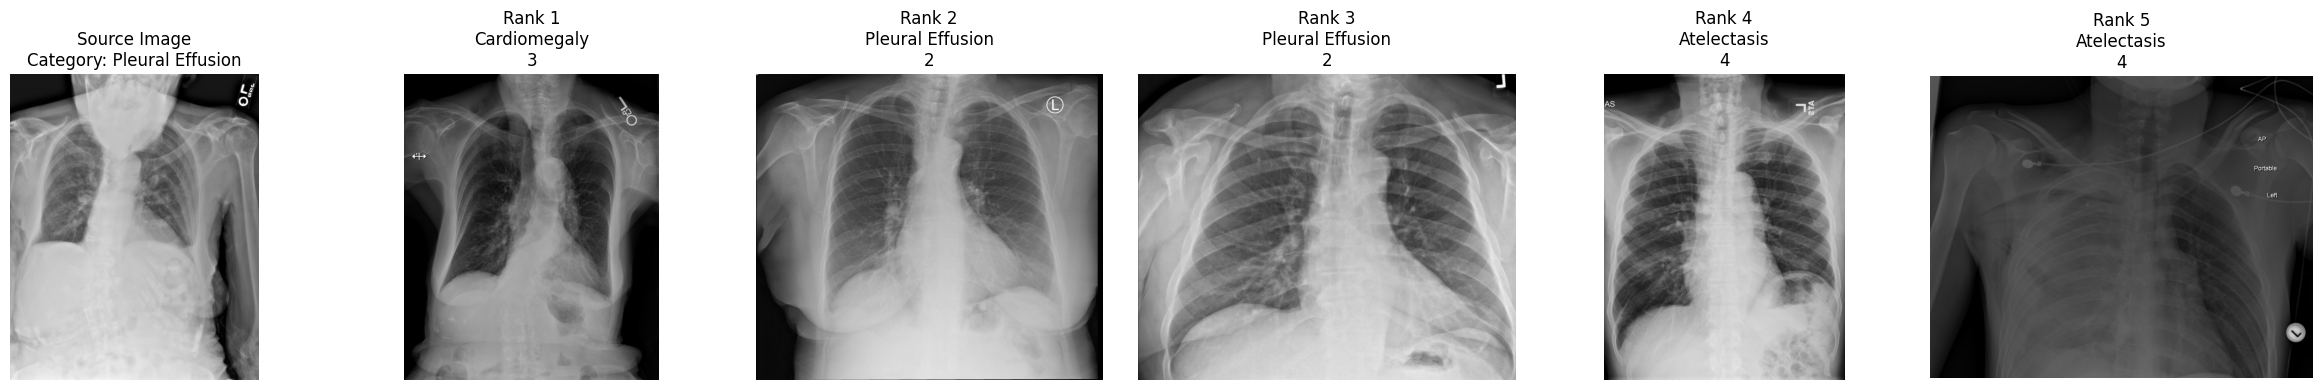

In [12]:
display_source_and_results(doc_index=40, search_client=search_client, documents=documents, k=5)

### 4. Optimizing Performance and Image Search ⚡

This notebook demonstrates a robust baseline for using AI Search with medical images. However, real-world scenarios require continuous improvement. Future updates might include:
- **Model Fine‑Tuning:** Adjusting neural network parameters for better classification.
- **Performance Benchmarking:** Evaluating search precision and recall.
- **Iterative Tuning:** Enhancing the sparse embedding space for more effective similarity matching.

Iterative tuning is common in Generative AI applications. While the initial results are promising, each adjustment can help further optimize retrieval accuracy and clinical relevance.

---

## 📖 Further Learning

For additional insights and advanced techniques, please refer to our colleagues’ work at:  
[Microsoft Healthcare AI Examples](https://github.com/microsoft/healthcareai-examples/blob/main/azureml/medimageinsight/adapter-training.ipynb) 📘

---

Embrace the power of AI in healthcare and enjoy the journey of building innovative solutions that can impact patient care! Happy coding and exploring! 😊
